In [1]:
import data_processing
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os

import tensorflow as tf
from tensorflow import keras

import wandb
from wandb.keras import WandbCallback

In [2]:
print("TF: ", tf.__version__)
print("W&B: ", wandb.__version__)

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


TF:  2.1.0
W&B:  0.12.11


wandb: Currently logged in as: stephenx (use `wandb login --relogin` to force relogin)


True

In [3]:
def get_config(key) -> int:
    with open('../conf/config.yaml') as file:
        file = yaml.load(file, Loader=yaml.FullLoader)

    return file[key]

In [4]:
config = get_config('CONFIG')
paths = get_config('PATHS')
print(config)

{'IMG_SHAPE': [64, 64, 1], 'BATCH_SIZE': 128, 'EPOCHS': 100, 'LEARNING_RATE': 0.0006, 'VALIDATION_SPLIT': 0.1}


## Príprava dát

Náš ručne vytvorený dataset sa neukázal ako vhodný pre natrénovanie robustného riešenie, pravdepodobne kvôli tomu, že obsahuje fotky rôznej intenzity, tváre sú v rôznych polohách a veľkostiach. Aby sme boli na tomto datasete pri trénovaní úspešní pravdepodobne by dataset mal obsahovať viacero fotiek, čím by sa mohla vykompezovať ich rôznorodosť.

Preto sme sa rozhodli použiť existujúci Olivetti dataset, ktorý obsahuje iba tváre z predu, fotené z rovnakej vzdialenosti a pri fotky majú pomerne rovnakú svetelnú intenzitu.

Na tomto datasete sme dosiahli neporovnateľne lepšie výsledky pri rovnakej architektúre použitej neurónovej siete.

In [5]:
from sklearn.datasets import fetch_olivetti_faces
olivetti = fetch_olivetti_faces()
X = olivetti.images
y = olivetti.target

print(X.shape)
print(y.shape)

(400, 64, 64)
(400,)


Rozdelíme dáta v pomere 90/10/10

In [6]:
x_train, x_val, x_test = X[:360], X[360:380], X[380:]
y_train, y_val, y_test = y[:360], y[360:380], y[380:]

In [7]:
print(f'Train: {x_train.shape} - {y_train.shape}')
print(f'Val: {x_val.shape} - {y_val.shape}')
print(f'Test: {x_test.shape} - {y_test.shape}')

Train: (360, 64, 64) - (360,)
Val: (20, 64, 64) - (20,)
Test: (20, 64, 64) - (20,)


Vytvoríme páry fotografí pre siamskú sieť, každá jedna fotka z datasetu je spárovaná s 10 pozitívnymi a 10 negatívnymi fotkami.

In [8]:
(pairs_train, label_train) = data_processing.make_pairs(x_train, y_train, negatives=10)
(pairs_val, label_val) = data_processing.make_pairs(x_val, y_val, negatives=10)
(pairs_test, label_test) = data_processing.make_pairs(x_test, y_test, negatives=10)

print(f'Train: {pairs_train.shape} - {label_train.shape}')
print(f'Val: {pairs_val.shape} - {label_val.shape}')
print(f'Test: {pairs_test.shape} - {label_test.shape}')

Train: (7200, 2, 64, 64) - (7200, 1)
Val: (400, 2, 64, 64) - (400, 1)
Test: (400, 2, 64, 64) - (400, 1)


Vytvorenie dvojíc dát, ktoré sa budú púšťať do konvolučných sietí

In [12]:
x_train_1 = pairs_train[:, 0].astype("float32")  
x_train_2 = pairs_train[:, 1].astype("float32")

x_val_1 = pairs_val[:, 0].astype("float32")  
x_val_2 = pairs_val[:, 1].astype("float32")

x_test_1 = pairs_test[:, 0].astype("float32") 
x_test_2 = pairs_test[:, 1].astype("float32")

label_train = label_train.astype("float32") 
label_val = label_val.astype("float32") 
label_test = label_test.astype("float32") 

print(f'Train: {x_train_1.shape} - {x_train_2.shape}')
print(f'Val: {x_val_1.shape} - {x_val_2.shape}')
print(f'Test: {x_test_1.shape} - {x_test_2.shape}')

Train: (7200, 64, 64) - (7200, 64, 64)
Val: (400, 64, 64) - (400, 64, 64)
Test: (400, 64, 64) - (400, 64, 64)


***

## Vytváranie siete

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2

Ako metriku pre určenie rozdielnosti výstupu použijeme euklidovu vzdialenosť výstupných vektorov

In [13]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

Architektúra neurónovej siete: ukázalo sa ako dobré použiť zo začiatku filtre s väščím kernelom a postupne ich zmenšovať. Konvolučná sieť nám vytvorí výsledný feature vektor o veľkosti 4096. 

In [14]:
input = layers.Input(config['IMG_SHAPE'])

x = tf.keras.layers.BatchNormalization()(input)

x = layers.Conv2D(64, (5, 5), padding="same", activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(128, (4, 4), padding="same", activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(4096, activation="sigmoid")(x)
embedding_network = keras.Model(input, x)

input_1 = layers.Input(shape=config['IMG_SHAPE'])
input_2 = layers.Input(shape=config['IMG_SHAPE'])

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

Ako loss-funckiu použijeme Contrastive loss, ktorá hodnotí ako dobre sieť predpovedala rozdielnosť alebo podobnosť obrázkou

In [15]:
def loss(margin=1):
    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [16]:
optimizer = Adam(learning_rate=config['LEARNING_RATE'])
siamese.compile(loss=loss(margin=1), optimizer=optimizer, metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 4096)         17373316    input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

***

## Trénovanie siete

In [17]:
x_train_1 = np.expand_dims(x_train_1, axis=-1)  
x_train_2 = np.expand_dims(x_train_2, axis=-1)

x_val_1 = np.expand_dims(x_val_1, axis=-1)  
x_val_2 = np.expand_dims(x_val_2, axis=-1)

x_test_1 = np.expand_dims(x_test_1, axis=-1) 
x_test_2 = np.expand_dims(x_test_2, axis=-1)

print(f'Train: {x_train_1.shape} - {x_train_2.shape}')
print(f'Val: {x_val_1.shape} - {x_val_2.shape}')
print(f'Test: {x_test_1.shape} - {x_test_2.shape}')

Train: (7200, 64, 64, 1) - (7200, 64, 64, 1)
Val: (400, 64, 64, 1) - (400, 64, 64, 1)
Test: (400, 64, 64, 1) - (400, 64, 64, 1)


In [18]:
configs_4_wandb = dict(
    data_flag = 'face-reconition',
    epochs = config['EPOCHS'],
    learning_rate = config['LEARNING_RATE'],
    optimizer = 'adam',
    loss_fn = 'contrastive_loss'
)

In [19]:
run = wandb.init(project='face-recognition-with-siamese-nn', config=configs_4_wandb, group='train')

history = siamese.fit(
    [x_train_1, x_train_2],
    label_train,
    validation_data=([x_val_1, x_val_2], label_val),
    batch_size=config['BATCH_SIZE'], 
	epochs=config['EPOCHS'],
    verbose=True,
    callbacks=[WandbCallback()]
)

Train on 7200 samples, validate on 400 samples
Epoch 1/100
7200/7200 [==============================] - 12s 2ms/sample - loss: 0.1019 - accuracy: 0.8839 - val_loss: 0.3861 - val_accuracy: 0.5000
Epoch 2/100
7200/7200 [==============================] - 8s 1ms/sample - loss: 0.0525 - accuracy: 0.9751 - val_loss: 0.3285 - val_accuracy: 0.5000
Epoch 3/100
7200/7200 [==============================] - 8s 1ms/sample - loss: 0.0382 - accuracy: 0.9897 - val_loss: 0.1040 - val_accuracy: 0.8975
Epoch 4/100
7200/7200 [==============================] - 8s 1ms/sample - loss: 0.0296 - accuracy: 0.9969 - val_loss: 0.0454 - val_accuracy: 1.0000
Epoch 5/100
7200/7200 [==============================] - 8s 1ms/sample - loss: 0.0236 - accuracy: 0.9989 - val_loss: 0.0482 - val_accuracy: 1.0000
Epoch 6/100
7200/7200 [==============================] - 8s 1ms/sample - loss: 0.0196 - accuracy: 0.9996 - val_loss: 0.0537 - val_accuracy: 0.9950
Epoch 7/100
7200/7200 [==============================] - 8s 1ms/sample

In [20]:
siamese.save(paths['MODEL_PATH'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/siamese_model/assets


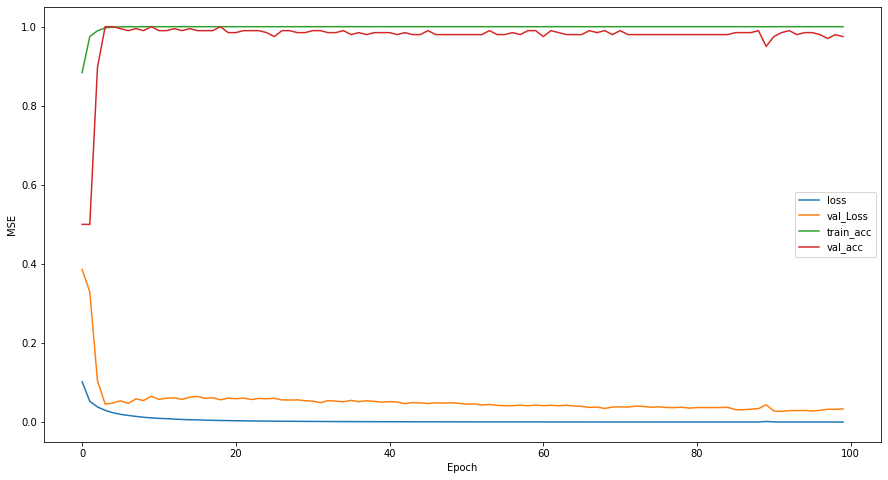

In [21]:
plt.figure(figsize=(15,8))

plt.xlabel('Epoch')
plt.ylabel('MSE')

plt.plot(siamese.history.history['loss'], label='loss')
plt.plot(siamese.history.history['val_loss'], label='val_Loss')
plt.plot(siamese.history.history['accuracy'], label='train_acc')
plt.plot(siamese.history.history['val_accuracy'], label='val_acc')
plt.legend()

***

## Vyhodnotenie úpešnosti siete

In [27]:
predictions = siamese.predict([x_test_1, x_test_2])

Spočítame úspešnosť siete, ako threshold hodnotu pre podobnosť zvolíme honodtu 0.6

In [33]:
true_positives = 0
false_positives = 0
for i in range(0, len(x_test_1)):
    if (predictions[i][0] >= 0.6 and label_test[i] == 1) or \
        (predictions[i][0] <= 0.6 and label_test[i] == 0):
        true_positives += 1
    elif (predictions[i][0] >= 0.6 and label_test[i] == 0) or \
        (predictions[i][0] <= 0.6 and label_test[i] == 1):
        false_positives += 1

print(f'TRUE POSSITIVES: {true_positives}')
print(f'FALSE POSSITIVES: {false_positives}')

TRUE POSSITIVES: 378
FALSE POSSITIVES: 22


In [34]:
def draw_evaluation(sample, s_class, similarity):
    plt.figure(figsize=(4, 6))
    plt.title("Similarity: {:.2f}".format(similarity))
    pair = np.hstack((sample, s_class))
    plt.imshow(pair, cmap=plt.cm.gray)

Zobrazíme niekoľko pozitívnych predikcií rovnakej osoby

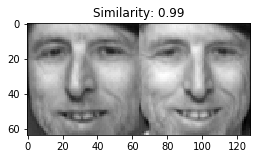

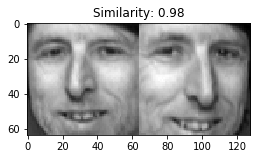

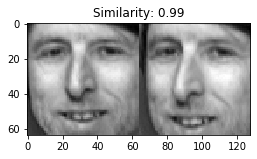

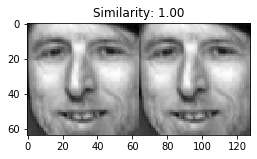

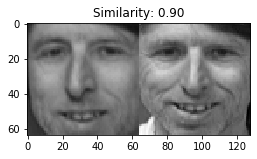

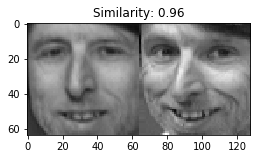

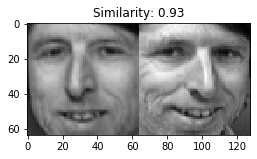

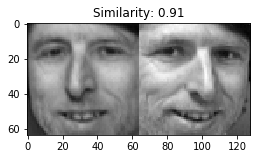

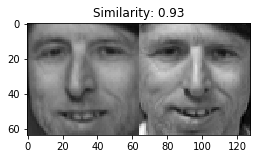

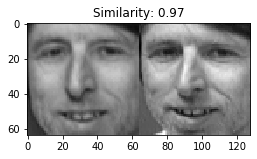

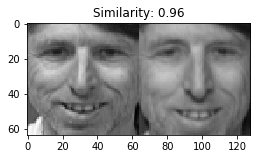

In [37]:
counter = 10
for i in range(59, len(x_test_1)):
    if predictions[i][0] >= 0.6 and label_test[i] == 1:
        draw_evaluation(x_test_1[i, :, :, 0], x_test_2[i, :, :, 0], predictions[i][0])
        counter -= 1
    
    if counter < 0:
        break

Zobrazíme niekoľko pozitívnych predikcií rôznych osôb

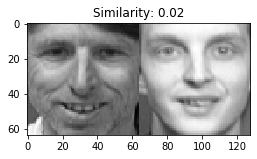

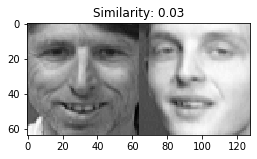

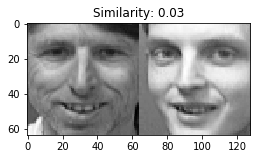

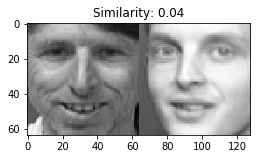

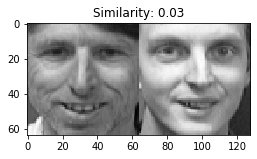

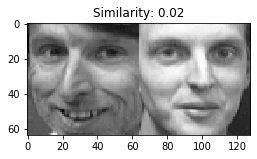

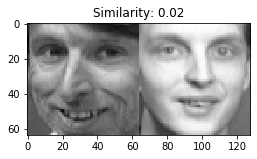

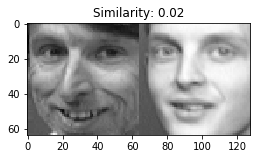

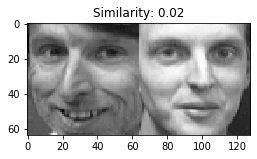

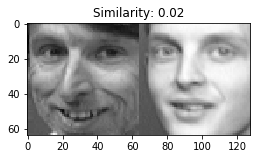

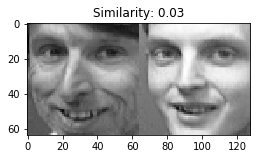

In [41]:
counter = 10
for i in range(95, len(x_test_1)):
    if predictions[i][0] <= 0.6 and label_test[i] == 0:
        draw_evaluation(x_test_1[i, :, :, 0], x_test_2[i, :, :, 0], predictions[i][0])
        counter -= 1
    
    if counter < 0:
        break

Zobrazíme niekoľko falošne pozitívnych predikcií

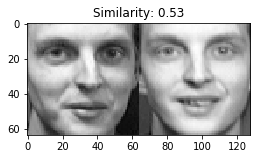

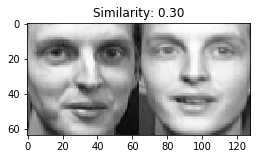

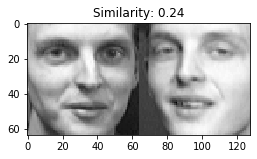

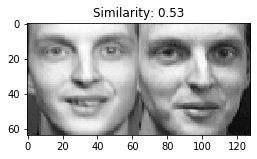

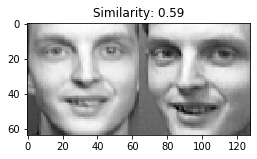

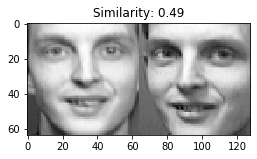

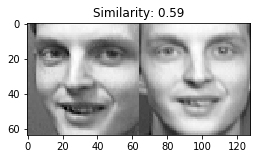

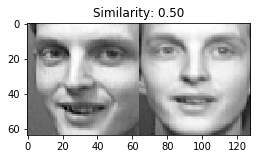

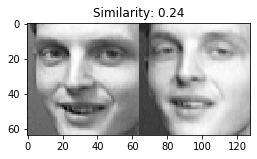

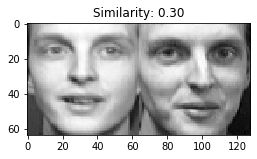

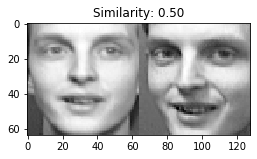

In [42]:
counter = 10
for i in range(i, len(x_test_1)):
    if (predictions[i][0] >= 0.6 and label_test[i] == 0) or \
        (predictions[i][0] <= 0.6 and label_test[i] == 1):
        draw_evaluation(x_test_1[i, :, :, 0], x_test_2[i, :, :, 0], predictions[i][0])
        counter -= 1
    
    if counter < 0:
        break